In [1]:
%matplotlib inline

import os
import glob
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

from astropy.io import fits
from astropy.table import Table, Column

from desispec.interpolation import resample_flux

mpl.rc('font', family='serif', size=10)

In [2]:
# Some simulation parameters
night   = '20190101'
expid   = 4 # exposure ID number, can use to simulate more than one DESI exposure

In [3]:
globpath = '../galaxy_sim_catalog/gal_spectra/*expid%03d*.fits' % expid

# Sort out 20190102 which I haven't added SN to yet
all_spectra = [fn for fn in glob.glob(globpath) 
                 if not '20190102' in os.path.basename(fn)]

print len(all_spectra), "total spectra"

11400 total spectra


## Read spectra into table

In [5]:
spec_table = Table(names=('ID', 'OBJTYPE', 'HAS_SN', 'SN_EPOCH', 'REDSHIFT', 
                          'MAG', 'WAVE', 'FLUX', 'IVAR'),
                 dtype=('S23', 'S4', 'S5', 'S5', float, float, list, list, list))

for n, spectra in enumerate(all_spectra):
        
    if "-with-SN" in spectra:
        specid = int(spectra[-20:-15])
    else:
        specid = int(spectra[-10:-5])
    
        
    with fits.open(spectra, memmap=0) as hdul:

        specid  = os.path.basename(spectra)[8:31]
        objtype = hdul[0].header['OBJTYPE']

        if objtype in ['SKY', 'FSTD']:
            continue
        else:
            has_sn  = hdul[0].header['HAS_SN']
            Z    = hdul[0].header['REDSHIFT']
            mag  = hdul[0].header['MAG']
            wave = hdul[1].data / (Z+1)
            if not has_sn:
                flux = hdul[2].data * 1e-17 # gal fluxes aren't in units
                sn_epoch = "n/a"
            else:
                flux = hdul[2].data
                sn_epoch = hdul[0].header['SN_EPOCH']
            ivar = hdul[3].data * 1e-17

            new_row = [specid, objtype, has_sn, sn_epoch, Z, mag, wave, flux, ivar]
            spec_table.add_row(new_row)

In [6]:
len(spec_table)

10800

In [7]:
spec_table[:10]

ID,OBJTYPE,HAS_SN,SN_EPOCH,REDSHIFT,MAG,WAVE,FLUX,IVAR
str23,str4,str5,str5,float64,float64,object,object,object
20190401-expid004-00480,BGS,Ia,0.0,0.239963606,17.66655159,"[ 2878.47154054 2879.27801582 2880.0844911 ..., 7929.42643456 7930.23290985 7931.03938513]","[ 3.34904029e-16 1.56034675e-16 1.05328637e-16 ..., 1.44351531e-16 1.96318432e-16 4.09805504e-16]","[ 3.55154584e-20 1.02079852e-19 1.13137021e-19 ..., 6.70146743e-18 5.48521083e-18 2.52316763e-19]"
20190101-expid004-00231,BGS,Ia,0.0,0.12860250473,16.3117465973,"[ 3162.49515326 3163.38120482 3164.26725637 ..., 8711.83623473 8712.72228628 8713.60833783]","[ 5.73340152e-16 4.86429852e-16 4.75619966e-16 ..., 5.35301199e-16 6.49569047e-16 1.13298841e-15]","[ 2.52107154e-20 7.20025374e-20 7.88461193e-20 ..., 2.82263638e-18 2.18206296e-18 9.81923487e-20]"
20190101-expid004-00224,BGS,Ia,0.0,0.0917735546827,16.5328006744,"[ 3269.17604467 3270.09198552 3271.00792637 ..., 9005.71382513 9006.62976598 9007.54570683]","[ 1.42345373e-16 4.86804861e-16 1.09589806e-16 ..., 5.10241871e-16 6.33744578e-16 9.78909561e-16]","[ 3.54782450e-20 1.01910577e-19 1.12705982e-19 ..., 2.94555294e-18 2.28153949e-18 1.02758974e-19]"
20190401-expid004-00495,BGS,Ia,0.0,0.0737213119864,17.2675952911,"[ 3324.13998989 3325.07133026 3326.00267062 ..., 9157.12493135 9158.05627172 9158.98761208]","[ -1.97294663e-16 1.16187424e-16 1.48275412e-16 ..., 2.71725422e-16 3.54164910e-16 5.71728970e-16]","[ 4.19935945e-20 1.20448793e-19 1.33079712e-19 ..., 4.88493744e-18 3.87629450e-18 1.76185464e-19]"
20190101-expid004-00202,BGS,False,n/a,0.365126162767,18.7889194489,"[ 2614.55684355 2615.28937658 2616.0219096 ..., 7202.41136935 7203.14390238 7203.8764354 ]","[ -7.15045891e-17 -7.55193466e-17 -1.21839998e-16 ..., 8.01613519e-17 1.27640255e-16 1.00381193e-16]","[ 4.22650196e-20 1.21455718e-19 1.34733479e-19 ..., 8.45498031e-18 7.13840077e-18 3.32359231e-19]"
20190101-expid004-01938,BGS,Ia,0.0,0.253593295813,15.4672794342,"[ 2847.17536628 2847.97307316 2848.77078005 ..., 7843.2137665 7844.01147338 7844.80918027]","[ 8.07171394e-16 6.43446960e-16 5.77637505e-16 ..., 1.48384392e-15 1.86312879e-15 2.92419116e-15]","[ 2.38957228e-20 6.87033340e-20 7.60089609e-20 ..., 1.14025234e-18 8.60394292e-19 3.83651118e-20]"
20190101-expid004-04117,BGS,Ia,0.0,0.197214454412,18.563791275,"[ 2981.25364091 2982.08891315 2982.9241854 ..., 8212.56388868 8213.39916092 8214.23443316]","[ 1.86583292e-17 2.85546307e-17 -2.92556289e-17 ..., 6.45242045e-17 7.23472297e-17 1.73001857e-16]","[ 3.96941584e-20 1.14115847e-19 1.26565148e-19 ..., 1.03152466e-17 8.89798929e-18 4.17773074e-19]"
20190101-expid004-02395,BGS,False,n/a,0.330918580294,19.3047332764,"[ 2681.75679866 2682.50815943 2683.25952019 ..., 7387.52944086 7388.28080163 7389.03216239]","[ -2.25514846e-16 1.11150800e-16 5.74941546e-17 ..., 6.58734148e-17 7.54973105e-17 1.20845119e-16]","[ 4.50495712e-20 1.29453404e-19 1.43604461e-19 ..., 9.69283707e-18 8.41879033e-18 3.96345994e-19]"
20190101-expid004-02738,BGS,Ia,0.0,0.0487702526152,15.2466878891,"[ 3403.22386364 3404.17736131 3405.13085899 ..., 9374.98005001 9375.93354769 9376.88704537]","[ 1.88566233e-15 1.45304167e-15 1.51467087e-15 ..., 1.29037836e-15 1.70371762e-15 2.52794971e-15]","[ 1.64194350e-20 4.71061038e-20 5.18186099e-20 ..., 1.31380631e-18 9.94000918e-19 4.43673023e-20]"


In [8]:
SN_fluxes = {}

for specid in set(spec_table['ID']):
    
    # Get the galaxy + SN host pair
    specs  = spec_table[spec_table['ID'] == specid]
    snhost = specs[specs['HAS_SN'] != 'False']
    gal    = specs[specs['HAS_SN'] == 'False']
    
    # Remove the galaxy from the supernova
    sn_flux = snhost['FLUX'] - gal['FLUX']
    sn_wave = snhost['WAVE']
    
    # Save the SN-only flux
    SN_fluxes[specid] = [sn_wave, sn_flux]

In [9]:
# Sort the table so we can read through it easier
spec_table.sort('ID')

In [10]:
galaxies = spec_table[spec_table['HAS_SN']=="False"]
sn_hosts = spec_table[spec_table['HAS_SN']!="False"]

print len(galaxies), len(sn_hosts)

5400 5400


## Plots of Spectra

In [11]:
closedim_galaxies = galaxies[(galaxies['MAG'] > 19) & (galaxies['REDSHIFT'] < 0.1)]
closedim_sn_hosts = sn_hosts[(galaxies['MAG'] > 19) & (galaxies['REDSHIFT'] < 0.1)]

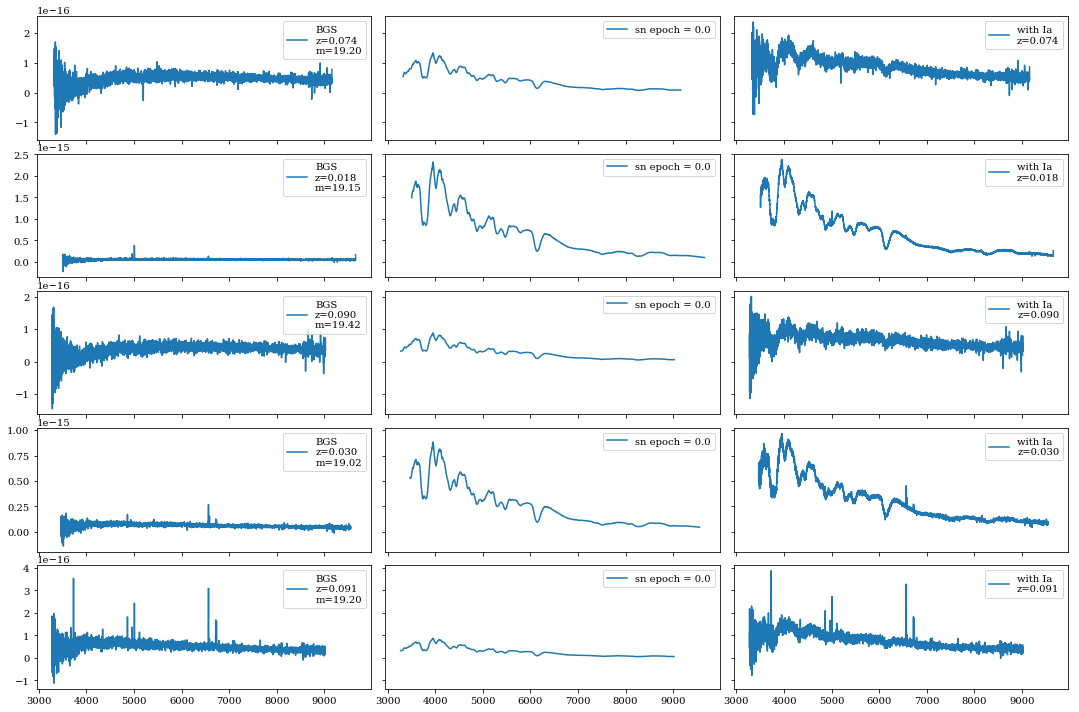

In [12]:
nplots = 5

fig, axes = plt.subplots(nplots,3, figsize=(15, nplots*2), 
                         sharex=True, sharey='row')

for i, galaxy in enumerate(closedim_galaxies[:nplots]):
    gal_label="%s\nz=%.3f\nm=%.2f" % (galaxy['OBJTYPE'], galaxy['REDSHIFT'], galaxy['MAG'])
    axes[i,0].plot(galaxy['WAVE'], galaxy['FLUX'], label=gal_label)
    axes[i,0].legend(loc='upper right')
    
for i, sn_host in enumerate(closedim_sn_hosts[:nplots]):
    sn_label = "with %s\nz=%.3f" % (sn_host['HAS_SN'], sn_host['REDSHIFT'])
    axes[i,2].plot(sn_host['WAVE'], sn_host['FLUX'], label=sn_label)
    axes[i,2].legend(loc='upper right')
    
    snid = sn_host['ID']
    sn_label="sn epoch = %.1f" % 0
    axes[i,1].plot(SN_fluxes[snid][0][0], 
                   SN_fluxes[snid][1][0], label=sn_label)
    axes[i,1].legend(loc='upper right')

fig.tight_layout(h_pad=0, w_pad=0)

# plt.savefig('../plots/galaxies_with_sn.png', format='png', 
#             dpi=300, bbox_inches='tight')

In [13]:
from collections import Counter

counts = Counter(spec_table['HAS_SN'])

print [(v, k) for v, k in zip(counts.values(), counts.keys())]

[(5400, 'Ia'), (5400, 'False')]


## Random Forest Classifier

In [14]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier

In [24]:
allwaves = np.concatenate(spec_table['WAVE'])
min_wave = np.min(allwaves)
max_wave = np.max(allwaves)

print min_wave, max_wave

step= 1.0 # 1.0 # A
global_wavelength_grid = np.arange(min_wave, max_wave+step, step)
# print global_wavelength_grid

2549.45077685 9736.29854916


In [25]:
# Resample spectra to a common wavelength grid
resample_fluxes = []
for spectra in spec_table:
    wave = spectra['WAVE']
    flux = spectra['FLUX']
    ivar = spectra['IVAR']
#     spec_flux_resample = resample_flux(
#                                  global_wavelength_grid, wave, flux,
#                                  extrapolate=True
#                                 )
    spec_flux_resample, spec_ivar_resample = resample_flux(
                             global_wavelength_grid, wave, flux,
                             ivar=ivar, extrapolate=False
                            )
    spec_flux_resample = np.asarray(spec_flux_resample) 
    resample_fluxes.append(spec_flux_resample / np.linalg.norm(spec_flux_resample))
    
spec_table['RESAMPLED_FLUX'] = resample_fluxes

In [27]:
# Load resampled spectrum data into one overall table
# each column will be one bin in the global wavelength grid
table  = []
names  = []
dtypes = []

# for i in range(len(fluxes)):
#     tablerow = np.append(fluxes[i], objtypes[i])
for spec in spec_table:
    tablerow = np.append(spec['RESAMPLED_FLUX'], spec['HAS_SN'])
    table.append(tablerow)

# for i in range(len(spec_table['FLUX'][0])):
for i in range(len(global_wavelength_grid)):
    names.append("w%d" % i)
    dtypes.append(np.float32)
    
names.append('HAS_SN')
dtypes.append('S')

data = Table(rows=table, names=names, dtype=dtypes)

In [28]:
df = data.to_pandas()

In [29]:
df[:5]

,w0,w1,w2,w3,w4,w5,w6,w7,w8,w9,...,w7179,w7180,w7181,w7182,w7183,w7184,w7185,w7186,w7187,HAS_SN
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Ia
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Ia
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False


In [30]:
df['is_train'] = np.random.uniform(0, 1, len(df)) <= 0.75

In [31]:
# We now split the dataframes into a test and training dataset
train, test = df[df['is_train']==True], df[df['is_train']==False]
print 'Number of observations in the training data:', len(train)
print 'Number of observations in the test data:',len(test)

Number of observations in the training data: 8015
Number of observations in the test data: 2785


In [32]:
train_count = Counter(train['HAS_SN'])
test_count  = Counter(test['HAS_SN'])

print "training / testing counts"
for k in train_count.keys():
    print "%s: %d / %d" % (k, train_count[k], test_count[k])

training / testing counts
Ia: 4005 / 1395
False: 4010 / 1390


In [33]:
features = df.columns[:-2]
features

Index([u'w0', u'w1', u'w2', u'w3', u'w4', u'w5', u'w6', u'w7', u'w8', u'w9',
       ...
       u'w7178', u'w7179', u'w7180', u'w7181', u'w7182', u'w7183', u'w7184',
       u'w7185', u'w7186', u'w7187'],
      dtype='object', length=7188)

In [34]:
# train['species'] has the "true" species names
# in order to compare later it needs to be coded into integers (0, 1, 2)

y, objtypes = pd.factorize(train['HAS_SN'])

# Now we train the random forest
clf = RandomForestClassifier(n_jobs=1, 
                             random_state=0,
                             verbose=0)

clf.fit(train[features], y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=0,
            verbose=0, warm_start=False)

In [35]:
# Apply the classifier to the test data
clf.predict(test[features])

array([0, 0, 0, ..., 0, 1, 0])

In [36]:
# Convert back to english
preds = [objtypes[i] for i in clf.predict(test[features])]

In [37]:
from pandas_ml import ConfusionMatrix

cm = ConfusionMatrix(test['HAS_SN'].tolist(), preds)
cm.print_stats()

population: 2785
P: 1395
N: 1390
PositiveTest: 1566
NegativeTest: 1219
TP: 808
TN: 632
FP: 758
FN: 587
TPR: 0.579211469534
TNR: 0.454676258993
PPV: 0.515964240102
NPV: 0.518457752256
FPR: 0.545323741007
FDR: 0.484035759898
FNR: 0.420788530466
ACC: 0.517055655296
F1_score: 0.545761567038
MCC: 0.0341538157808
informedness: 0.0338877285269
markedness: 0.0344219923581
prevalence: 0.500897666068
LRP: 1.06214240455
LRN: 0.92546844517
DOR: 1.14768084217
FOR: 0.481542247744


In [38]:
# Display how well the classifier did via a confusion matrix

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(test['HAS_SN'], preds, labels=objtypes)
print objtypes
print cm

Index([u'Ia', u'False'], dtype='object')
[[808 587]
 [758 632]]


In [39]:
correct = 0
incorrect = 0
for true, pred in zip(test['HAS_SN'], preds):
    if true == pred:
        correct += 1
#         print true, pred
    else:
        incorrect+= 1
#         print true, pred
        
print correct, incorrect

1440 1345


In [ ]:
norm_cm = []
for i in cm:
    a = 0
    tmp_arr = []
    a = sum(i, 0)
    for j in i:
        tmp_arr.append(float(j)/float(a))
    norm_cm.append(tmp_arr)

fig = plt.figure()
plt.clf()
ax = fig.add_subplot(111)
ax.set_aspect(1)
res = ax.imshow(np.array(norm_cm), cmap='Wistia',
                interpolation='nearest')

width, height = cm.shape

for x in xrange(width):
    for y in xrange(height):
        ax.annotate(str(cm[x][y]), xy=(y, x), 
                    color='k',
                    horizontalalignment='center',
                    verticalalignment='center')

# cb = fig.colorbar(res)
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top')
plt.xticks(range(width), objtypes[:width])
plt.yticks(range(height), objtypes[:height])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.savefig('../plots/rf_snhost_classify_confusion_matrix.png', format='png', 
            dpi=300, bbox_inches='tight')

In [41]:
sn_medfluxes  = [np.median(flux) for flux in sn_hosts['FLUX']]
gal_medfluxes = [np.median(flux) for flux in galaxies['FLUX']]

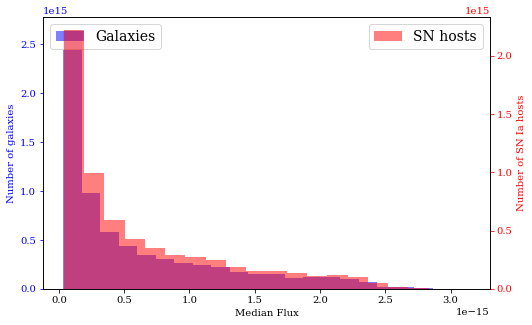

In [42]:
fig, ax = plt.subplots(1,1,figsize=(8,5))

ax.hist(gal_medfluxes, bins=20, normed=1, 
        color='b', alpha=0.5, label='Galaxies')

ax2 = ax.twinx()
ax2.hist(sn_medfluxes,  bins=20, normed=1, 
         color='r', alpha=0.5, label='SN hosts')

ax.set(xlabel='Median Flux')
ax.set_ylabel(ylabel='Number of galaxies', color='b')
ax.tick_params('y', colors='b')

ax2.set_ylabel('Number of SN Ia hosts', color='r')
ax2.tick_params('y', colors='r')

# ax.axvline(0.60, ls='--')

ax.legend(loc='upper left', fontsize=14)
ax2.legend(loc='upper right', fontsize=14)